[View in Colaboratory](https://colab.research.google.com/github/ip01/intro_to_competitive_data_science/blob/master/models/DDI-ip01.ipynb)

# Drug-drug Interactions

Predicts missing Drug-drug interaction.
Nodes of DDI graph are embedded via skip-gram over 2nd order biased random walk.
The distance matrix is computed from cosine similarity of embedding vectors.
Per each pair of drugs, 2 digitized 2-D pseudo-CDFs (unnormalized) of distances to all other drugs are computed: 1 for all linked pairs, and 1 for all unlinked pairs.
Memberwise difference of this CDFs is flattened and used as input layer for binary classifiers (RF, XGB, Logistic Regression, KNN, Extreme Trees).
Iterative ensemble learning applied to the top of these classifiers.
Trained on snapshots (2009 vs. 2012) of the DrugBank database, downloaded from http://seeslab.info/downloads/drug-drug-interactions/
(data: Guimera, R, Sales-Pardo, M., "A network inference method for large-scale unsupervised identification of novel drug-drug interactions" PLOS Comput. Biol. 9 (12) , e1003374 (2013).)
    
## TO DO:
 - Vectorize/numba/Cython np.apply_along_axis(get_featv,...
 
## TO IMPROVE:
 - optimize ROC AUC (see DeepSuperLearner_AUC below)
 - play with node2vec params (especially p, q). Quality of embedding could be remotely assessed by pharmacological similarity of neighbours/cluters of drugs as implied by resulted distances.
 - replace node2vec embedding by alternative (like VERSE or GCNs, see https://github.com/chihming/awesome-network-embedding and http://snap.stanford.edu/proj/embeddings-www/)
 - replace cosine similarity by alternatives
 - new features: for drugs d1 and e2 - concatenate Hadamard product of embeddings(d1) and avg(embeddings(closest_linked(d2, threshold2, d1, threshold1))) and reciprocal one. Here closest_linked(d2, threshold2, d1, threshold1) - drugs from threshold2-vicinity of d2 linked to drugs from threshold1-vicinity of d1 
 - new features: apply clustering (HDBSCAN or whatever), concatenate Hadamard product of embeddings(d1) and avg(embeddings(cluster_linked(d2, d1))) and reciprocal one. Here cluster_linked(d2, d1) - drugs from the cluster of d2 linked to drugs from the cluster of d1 
 - apply ensemble (say https://github.com/levyben/DeepSuperLearner) for alternative hyperparams of learners, embeddings, digitization etc.
 - top-level ensemble based on scores for (i,j) and (j,i). Input - min and max of these 2 scores. Alternative approach - transform feature vector to be independent on direction of link, like DSym(i,j) = DSym(j,i) = D(i,j).T*D(j,i)

## Install Dependancies

In [0]:
!pip install -q node2vec
!pip install -q git+https://github.com/levyben/DeepSuperLearner

## Download DrugBank data

In [3]:
!curl -o drugbank_200901.dat http://seeslab.info/media/filer_public/fe/0c/fe0c42f0-0b36-4a75-8cee-56075027d67c/drugbank_200901.dat
!curl -o drugbank_201204.dat http://seeslab.info/media/filer_public/ea/ea/eaea3467-d68e-4bca-8eaa-d4d68c413c8b/drugbank_201204.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  299k  100  299k    0     0   299k      0  0:00:01  0:00:01 --:--:--  247k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  518k  100  518k    0     0   518k      0  0:00:01  0:00:01 --:--:--  442k


In [0]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import scipy.sparse as sp
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.stats.mstats import mquantiles
#import qgrid
from node2vec import Node2Vec
import networkx as nx
from itertools import islice
from sklearn.ensemble.forest import ExtraTreesClassifier as ExtremeRandomizedTrees
from sklearn.neighbors import KNeighborsClassifier as kNearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble.forest import RandomForestClassifier

from xgboost.sklearn import XGBClassifier
from deepSuperLearner import *
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
#import hdbscan
np.random.seed(42)

## Prepare Ground Truth

In [0]:
def prepare_GT(filenameOldDDIList, filenameNewDDIList):
    """Prepare Ground Truth list of DDI
    Parameters
    ----------
    filenameOldDDIList: file name of old (base) DDI List
    filenameOldDDIList: file name of old (updated) DDI List
    Returns
    -------
    m1: symmetric adjacency matrix of old DDI
    edgesNew: list of new edges (each edge is a pair of DrugIDs)
    lookupDrugName2ID: dictionary DrugName -> DrugID
    """
    df1=pd.read_csv(filenameOldDDIList,sep=' ', header = None, names=['name1','name2'])
    df2=pd.read_csv(filenameNewDDIList,sep=' ', header = None, names=['name1','name2'])
    s1=set(df1.name1.unique()).union(set(df1.name2.unique()))
    s2=set(df2.name1.unique()).union(set(df2.name2.unique()))
    s=s1.union(s2)
    lookupDrugName2ID = {value: key for (key, value) in enumerate(sorted(s))}
    df1['d1']=df1.name1.replace(lookupDrugName2ID)
    df1['d2']=df1.name2.replace(lookupDrugName2ID)
    df2['d1']=df2.name1.replace(lookupDrugName2ID)
    df2['d2']=df2.name2.replace(lookupDrugName2ID)
    s1n=set(df1.d1.unique()).union(set(df1.d2.unique()))
    s2n=set(df2.d1.unique()).union(set(df2.d2.unique()))
    onlyIn1 = np.array(sorted(list(s1n-s2n))) # drugs excluded (or renamed) in new DDI List 
    onlyIn2 = np.array(sorted(list(s2n-s1n))) # drugs added (or renamed) in new DDI List 
    d1n=df1.d1.values
    d2n=df1.d2.values
    m1 = coo_matrix((np.ones(2*df1.shape[0],'int'), (np.hstack([d1n,d2n]),np.hstack([d2n,d1n]))))
    m1 = ((m1 + m1.transpose())>0).astype('int').tolil() # adjacency DDI matrix, old DDI List

    d1n=df2.d1.values
    d2n=df2.d2.values
    m2 = coo_matrix((np.ones(2*df2.shape[0],'int'), (np.hstack([d1n,d2n]),np.hstack([d2n,d1n]))))
    m2 = ((m2 + m2.transpose())>0).astype('int').tolil() # adjacency DDI matrix, new DDI List

    #jac12=cdist(m1[onlyIn1,:].toarray(),m2[onlyIn2,:].toarray(),'jaccard')
    #dfSimilar=pd.DataFrame.from_records(
    #    [[jac12[i,j],onlyIn1[i],onlyIn2[j],d_r[onlyIn1[i]],d_r[onlyIn2[j]]] for (i,j) in enumerate (np.argmin(jac12,1)) ],
    #    columns=['coeff','i1','i2','name1','name2']
    #)
    #dfSimilar.to_csv('similar.csv')
    dfIdentical=pd.DataFrame.from_records([
                ('glibenclamide','glyburide'),
                ('demecarium_bromide','demecarium'),
                ('ipratropium','ipratropium_bromide'),
                ('marinol','dronabinol'),
                ('echothiophate_iodide','echothiophate'),
                ('doxacurium','doxacurium_chloride'),
                ('aspirin','acetylsalicylic_acid'),
                ('salicylate-magnesium','magnesium_salicylate'),
                ('insulin-detemir','insulin_detemir')
            ],
            columns=['iOld','iNew'])
    dfIdentical.iOld.replace(lookupDrugName2ID,inplace=True)
    dfIdentical.iNew.replace(lookupDrugName2ID,inplace=True)
    
    # drugs renamed in new DDI List - keep the old names
    m2[dfIdentical.iOld,:]=m2[dfIdentical.iNew,:]
    m2[:,dfIdentical.iOld]=m2[:,dfIdentical.iNew]
    m1_orig=m1.copy()
    m2_orig=m2.copy()
    
    # drugs added in new DDI List - ignore them
    m2[onlyIn2,:]=0
    m2[:,onlyIn2]=0
    
    # drugs excluded in new DDI List - ignore them
    onlyIn1_noIdentical = list(set(onlyIn1)-set(dfIdentical.iOld))
    m1[onlyIn1_noIdentical,:]=0
    m1[:,onlyIn1_noIdentical]=0
    
    # all interactions of valid drugs in old DDI List
    sedg1 = set(zip(*m1.nonzero()))

    # all interactions of valid drugs in new DDI List
    sedg2 = set(zip(*m2.nonzero()))
    
    # interactions excluded in new DDI List - ignore them
    edgesObsolete=np.array(list(sedg1-sedg2))
    for e in edgesObsolete:
        m1[e[0],e[1]] = 0
        
    # squeeze: exclude drugs without valid interactions
    isValidDrugID=(np.diff(m1.tocsr().indptr) != 0)
    newDrugIDs=np.repeat(-1,m1.shape[0])
    newDrugIDs[isValidDrugID]=np.arange(isValidDrugID.sum())
    m1=m1[isValidDrugID,:][:,isValidDrugID]
    lookupDrugName2ID =  {k : newDrugIDs[v] for (k,v) in lookupDrugName2ID.items() if newDrugIDs[v]>=0}
    
    # interactions added in new DDI List - keep them as training set
    edgesNew=[ [newDrugIDs[a],newDrugIDs[b]]  
              for (a,b) in sedg2-sedg1
              if b>a and newDrugIDs[a]>=0 and newDrugIDs[b]>=0]
    edgesNew = np.unique(edgesNew, axis=0)
    return (m1, edgesNew, lookupDrugName2ID)

In [7]:
%%time
(m1, edgesNew, lookupDrugName2ID) = prepare_GT('drugbank_200901.dat', 'drugbank_201204.dat')
# reverse lookup:  DrugID -> DrugName
lookupDrugID2Name = np.array(sorted(lookupDrugName2ID, key=lookupDrugName2ID.get))

CPU times: user 4.3 s, sys: 48 ms, total: 4.35 s
Wall time: 4.36 s


## Save/Load Input DDI Matrix

In [8]:
%%time
# SAVE
def save_DDI_matrix(fnameOldEdges, fnameDrugID2Name, m1, lookupDrugID2Name):
    np.savetxt(fnameDrugID2Name,lookupDrugID2Name,fmt='%s')
    np.savetxt(fnameOldEdges,np.array(list(zip(*m1.nonzero()))),fmt='%d',delimiter=',')
save_DDI_matrix("old_edges.csv", "lookupDrugID2Name.csv", m1, lookupDrugID2Name)

CPU times: user 57 ms, sys: 4 ms, total: 61 ms
Wall time: 64.1 ms


In [10]:
%%time
# LOAD
def load_DDI_matrix(fnameOldEdges, fnameDrugID2Name):
    lookupDrugID2Name = np.genfromtxt(fnameDrugID2Name,dtype=np.unicode_)
    lookupDrugName2ID = {v:i for i,v in enumerate(lookupDrugID2Name)}
    data_ = np.genfromtxt(fnameOldEdges,delimiter=',',dtype='int')
    m1 = sp.coo_matrix((np.ones(data_.shape[0],int),(data_[:,0],data_[:,1]))).tolil()
    return (m1, lookupDrugID2Name, lookupDrugName2ID)

#m1, lookupDrugID2Name, lookupDrugName2ID = load_DDI_matrix("old_edges.csv", "lookupDrugID2Name.csv")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.4 µs


## Generate Train/Test data (links and non-links)

In [9]:
%%time
# Save Ground Trith - New Links and Non-Links
OVERSAMPLE_NEWLINKS = 5 # how much New Liks to obe oversampled vs. Non-Links
def get_nonlink(m1,edgesNew):
    """Generator of non-link pairs
    Parameters
    ----------
    m1: adjacency matrix of old DDI
    edgesNew: list of new edges, assume to contain distinct edges
    Returns
    -------
    non_link: pair of non-linked node IDs
    """
    n_validIDs=m1.shape[0]
    while True:
        i = np.random.randint(n_validIDs-1)
        j = i + 1 + np.random.randint(n_validIDs - i - 1)
        if m1[i,j]:
            continue
        edge = [i,j]
        if edge in edgesNew:
            continue
        yield edge
nonEdges = np.array(list(islice (get_nonlink(m1,edgesNew),len(edgesNew)*OVERSAMPLE_NEWLINKS)))
np.savetxt('GT_nonlinks.csv', nonEdges, fmt='%d',delimiter=',')
np.savetxt('GT_links.csv', edgesNew, fmt='%d',delimiter=',') 

CPU times: user 461 ms, sys: 8 ms, total: 469 ms
Wall time: 482 ms


## Compute DDI matrix embeddings and distances

In [0]:
def get_node2vec(m1,dimensions=64, p=1, q=1, walk_length=10, num_walks=1000, window=10, workers=8):
    G=nx.from_scipy_sparse_matrix(sp.triu(m1,1))
    node2vec = Node2Vec(G, dimensions=dimensions, p=p, q=q, walk_length=walk_length, num_walks=num_walks, workers=workers) 
    model = node2vec.fit(window=window, min_count=1, batch_words=4) 
    return model

In [11]:
%%time
model = get_node2vec(m1,dimensions=64, p=1, q=1, walk_length=30, num_walks=200, window=10, workers=2)

Generating walks (CPU: 2): 100%|██████████| 100/100 [04:18<00:00,  2.67s/it]



CPU times: user 3min 42s, sys: 1min 47s, total: 5min 30s
Wall time: 8min 21s


In [0]:
model.wv.save_word2vec_format("node2vec-embeddings_64_1_1_30_200_10.w2v")
model.save("node2vec-model_64_1_1_30_200_10.w2v")


In [0]:
def wv_toembed(wv):
    """Convert gensim Word2Vec embeddings to numpy array
    Parameters
    ----------
    wv: gensim.models.keyedvectors.Word2VecKeyedVectors
    Returns
    -------
    embeddings: 2-D ndarray of shape (N_WORDS, N_EMBEDDING_DIMS)
    ks: 1-D ndarray of represented "words" (vertices)
    Embeddidng vectors of non-represented "words" (vertices) are zero
    """
    (Nwords,Ndims) = wv.vectors.shape
    ks = [int(x) for x in wv.vocab.keys()]
    idxs = [v.index for (k,v) in wv.vocab.items()]
    row_ind = np.repeat(ks,Ndims)
    col_ind = [x for x in range(Ndims)]*Nwords
    embeddings = sp.csr_matrix((wv.vectors[idxs,:].reshape(-1), (row_ind, col_ind)), (np.max(ks)+1,Ndims))
    return (embeddings.toarray(),ks)

In [0]:
embeddings, ks = wv_toembed(model.wv)
dist=squareform(pdist(embeddings,'cosine'))

## Compute bins for CDFs of drug-drug distances

In [0]:
def get_dist_bins(v, analog_ratio = 0.04, n_bin_edges = 10):
    """Get adaptive bins for histogram of drug-drug distances, per each drug
    Parameters
    ----------
    dist: 1-D ndarray - vector of drug-drug distances
    analog_ratio: ratio of to be taken take into account as "near enough"
    n_bin_edges: number of bins to digitize distances 
    Returns
    -------
    bins: 1-D ndarray of bins (1, n_bin_edges+1)
    """
    bins = mquantiles(v,
                        prob=np.linspace(0,analog_ratio,n_bin_edges),
                        alphap=3/8, betap=3/8) #Blom. The resulting quantile estimates are approximately unbiased if dist is normally distributed
    return np.hstack((bins,np.inf))
# adaptive bins for histogram of drug-drug distances, per each drug
adaptive_bins = np.apply_along_axis(get_dist_bins, 1, dist)
# global bins for histogram of drug-drug distances, the same for each drug
global_bins = np.tile(get_dist_bins(dist),(dist.shape[0],1))

## Compute 2-D CDF matching features 

In [0]:
iLink,jLink=m1.nonzero()
iNoLink,jNoLink=np.where(m1.A==0)

In [0]:
def get_cdf2_feat(dist, i, j, iLink, jLink, iNoLink, jNoLink, bins):
    """For a pair of drugs, get features (as matrix) based on 2-D CDF matching, 
    Parameters
    ----------
    dist: 2-D ndarray - symmetric matrix of drug-drug distances
    i, j: IDs (scalars) of drugs in question
    iLink, jLink: IDs (vectors) of all drugs with DDI (edge between them) 
    iNoLink, jNoLink: IDs (vectors) of all drugs without DDI (edge between them) 
    bins: 2-D ndarray digitization bins
    Returns
    -------
    D: 2-D ndarray of features: "Hellinger-like" matching of 2-D empirical CDFs of distances 
    """
    DLink=np.histogramdd(np.vstack((dist[i,jLink],dist[iLink,j])).T,bins=(bins[i],bins[j]))[0].astype('int')
    DNoLink=np.histogramdd(np.vstack((dist[i,jNoLink],dist[iNoLink,j])).T,bins=(bins[i],bins[j]))[0].astype('int')
    return np.sqrt(DLink) - np.sqrt(DNoLink) 
def get_featv(ij):
    """For a pair of drugs, get feature vector
    Parameters
    ----------
    ij: pair of IDs (scalars) of drugs in question
    Returns
    -------
    D: 1-D ndarray of features
    """
    i,j = ij
    f1=get_cdf2_feat(dist, i, j, iLink, jLink, iNoLink, jNoLink, adaptive_bins).flatten()
    f2=get_cdf2_feat(dist, i, j, iLink, jLink, iNoLink, jNoLink, global_bins).flatten()
    return np.concatenate((f1, f2))  

## Prepare lables and feature matrices for train and test

In [0]:
def get_edges_and_labels(fname, label, test_size=0.2):
    D = np.genfromtxt(fname,delimiter=',',dtype='int')
    Y = np.repeat(label, D.shape[0])
    e_train, e_test, y_train, y_test = train_test_split(D, Y, shuffle=False, test_size=test_size)
    e_train = np.vstack((e_train,np.apply_along_axis(lambda x: [x[1],x[0]], 1, e_train)))
    e_test = np.vstack((e_test,np.apply_along_axis(lambda x: [x[1],x[0]], 1, e_test)))
    y_train = np.tile(y_train,2)
    y_test = np.tile(y_test,2)
    return (e_train, e_test, y_train, y_test)

e_train_nonlinks, e_test_nonlinks, y_train_nonlinks, y_test_nonlinks = get_edges_and_labels('GT_nonlinks.csv', label=0)
e_train_links, e_test_links, y_train_links, y_test_links = get_edges_and_labels('GT_links.csv', label=1)

In [19]:
%%time
X_test_links = np.apply_along_axis(get_featv, 1, e_test_links)
X_train_links = np.apply_along_axis(get_featv, 1, e_train_links)
X_test_nonlinks = np.apply_along_axis(get_featv, 1, e_test_nonlinks)
X_train_nonlinks = np.apply_along_axis(get_featv, 1, e_train_nonlinks)

CPU times: user 24min 28s, sys: 0 ns, total: 24min 28s
Wall time: 24min 29s


In [0]:
YeX_train = np.vstack((
	    np.concatenate((y_train_nonlinks.reshape(-1,1),e_train_nonlinks,X_train_nonlinks),1),
		np.tile(np.concatenate((y_train_links.reshape(-1,1),e_train_links,X_train_links),1),(OVERSAMPLE_NEWLINKS,1))
	))
np.random.shuffle(YeX_train)
YeX_test = np.vstack((
	    np.concatenate((y_test_nonlinks.reshape(-1,1),e_test_nonlinks,X_test_nonlinks),1),
		np.tile(np.concatenate((y_test_links.reshape(-1,1),e_test_links,X_test_links),1),(OVERSAMPLE_NEWLINKS,1))
	))
np.random.shuffle(YeX_test)

In [0]:
#SAVE
np.savez("YeX_train.npz", YeX_train)
np.savez("YeX_test.npz", YeX_test)

In [0]:
#LOAD
YeX_train=np.load("YeX_train.npz")['arr_0']
YeX_test=np.load("YeX_test.npz")['arr_0']

In [0]:
Y_test = YeX_test[:,0]
e_test = YeX_test[:,1:3]
X_test = YeX_test[:,3:]
Y_train = YeX_train[:,0]
e_train = YeX_train[:,1:3]
X_train = YeX_train[:,3:]

## Learning

Iteration: 0 Loss: 0.052871394733274894
Weights:  [1. 0. 0. 0. 0. 0.]
Iteration: 1 Loss: 0.005658641496184774
Weights:  [0.06253322 0.         0.48179426 0.45567252 0.         0.        ]
Iteration: 2 Loss: 0.004318063546237772
Weights:  [0.80626558 0.         0.19373442 0.         0.         0.        ]
Iteration: 3 Loss: 0.005255540597313461
Weights:  [0.44627804 0.         0.21489033 0.         0.33494907 0.00388255]


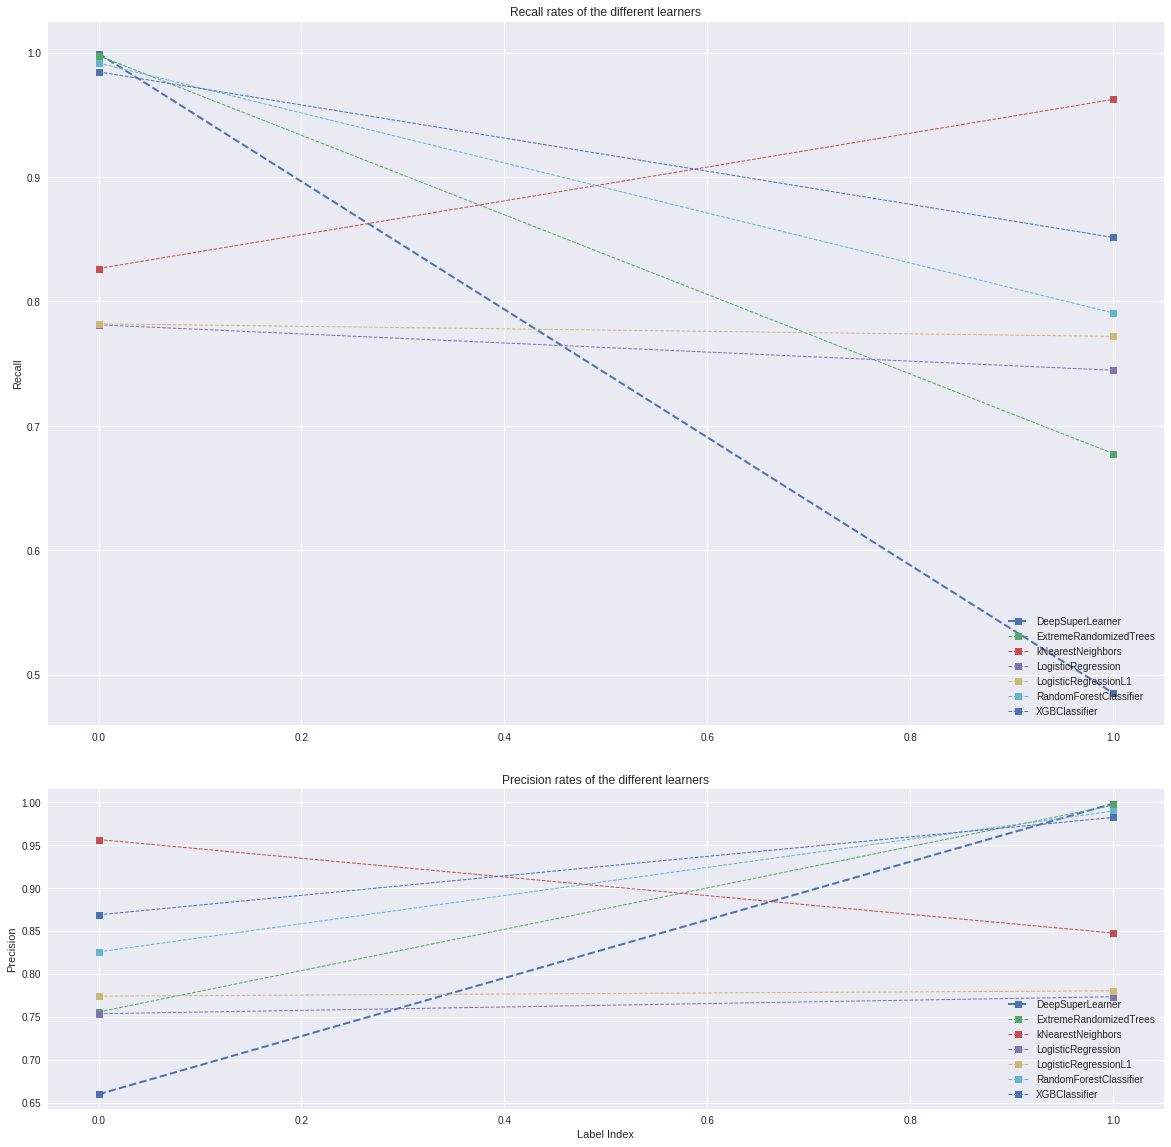

(array([0.99916178, 0.48535565]),
 array([0.65965689, 0.99827883]),
 [array([0.99748533, 0.67782427]),
  array([0.82648785, 0.9623431 ]),
  array([0.78122381, 0.74476987]),
  array([0.78206203, 0.77196653]),
  array([0.99161777, 0.79079498]),
  array([0.98449288, 0.85146444])],
 [array([0.75555556, 0.99630996]),
  array([0.95635306, 0.84745763]),
  array([0.75343573, 0.77324066]),
  array([0.77395272, 0.78012685]),
  array([0.82554082, 0.9895288 ]),
  array([0.86871302, 0.98214286])])

In [33]:
ERT_learner = ExtremeRandomizedTrees(n_estimators=200, max_depth=None, max_features=15)
kNN_learner = kNearestNeighbors(n_neighbors=11)
LR_learner = LogisticRegression(penalty='l2', C=1)
LR_learnerL1 = LogisticRegression(penalty='l1', C=0.1)
RFC_learner = RandomForestClassifier(n_estimators=200, max_depth=None)
XGB_learner = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.01)
Base_learners = {'ExtremeRandomizedTrees':ERT_learner, 'kNearestNeighbors':kNN_learner, 'LogisticRegression':LR_learner, 'LogisticRegressionL1':LR_learnerL1,
                     'RandomForestClassifier':RFC_learner, 'XGBClassifier':XGB_learner}
DSL_learner = DeepSuperLearner(Base_learners)
DSL_learner.fit(X_train, Y_train,max_iterations=50,sample_weight=None)
DSL_learner.get_precision_recall(X_test, Y_test, show_graphs=True)

### Use ROC AUC as optimization metrics for ensemble learning
Method _get_logloss(.) in DeepSuperLearner class is used as generic loss function. In principle, it could be replace by any other custom loss - like (1 - ROC_AUC)


In [0]:
from sklearn.metrics import roc_auc_score
class DeepSuperLearner_AUC(DeepSuperLearner):
    def _get_logloss(self, y, y_pred, sample_weight=None):
        """
        Calculate 1 - (ROC AUC) given ground-truth y and y-predictions
        Parameters
        ----------
        y: numpy array of shape [n,j] (ground-truth)
        y_pred: numpy array of shape [n,j] (predictions)
        
        Attributes
        ----------
        sample_weight: numpy array of shape [n,]
        
        Returns
        -------
        1-roc_auc_score: Complement to Area Under the Receiver Operating Characteristic Curve (ROC AUC)
        """
        return 1-roc_auc_score(y, y_pred[:,1], 
                        sample_weight=sample_weight)

Iteration: 0 Loss: 0.00027044552341493056
Weights:  [0.25 0.25 0.25 0.25]
Iteration: 1 Loss: 0.000316546688316377
Weights:  [0.24975578 0.24975578 0.25073265 0.24975578]


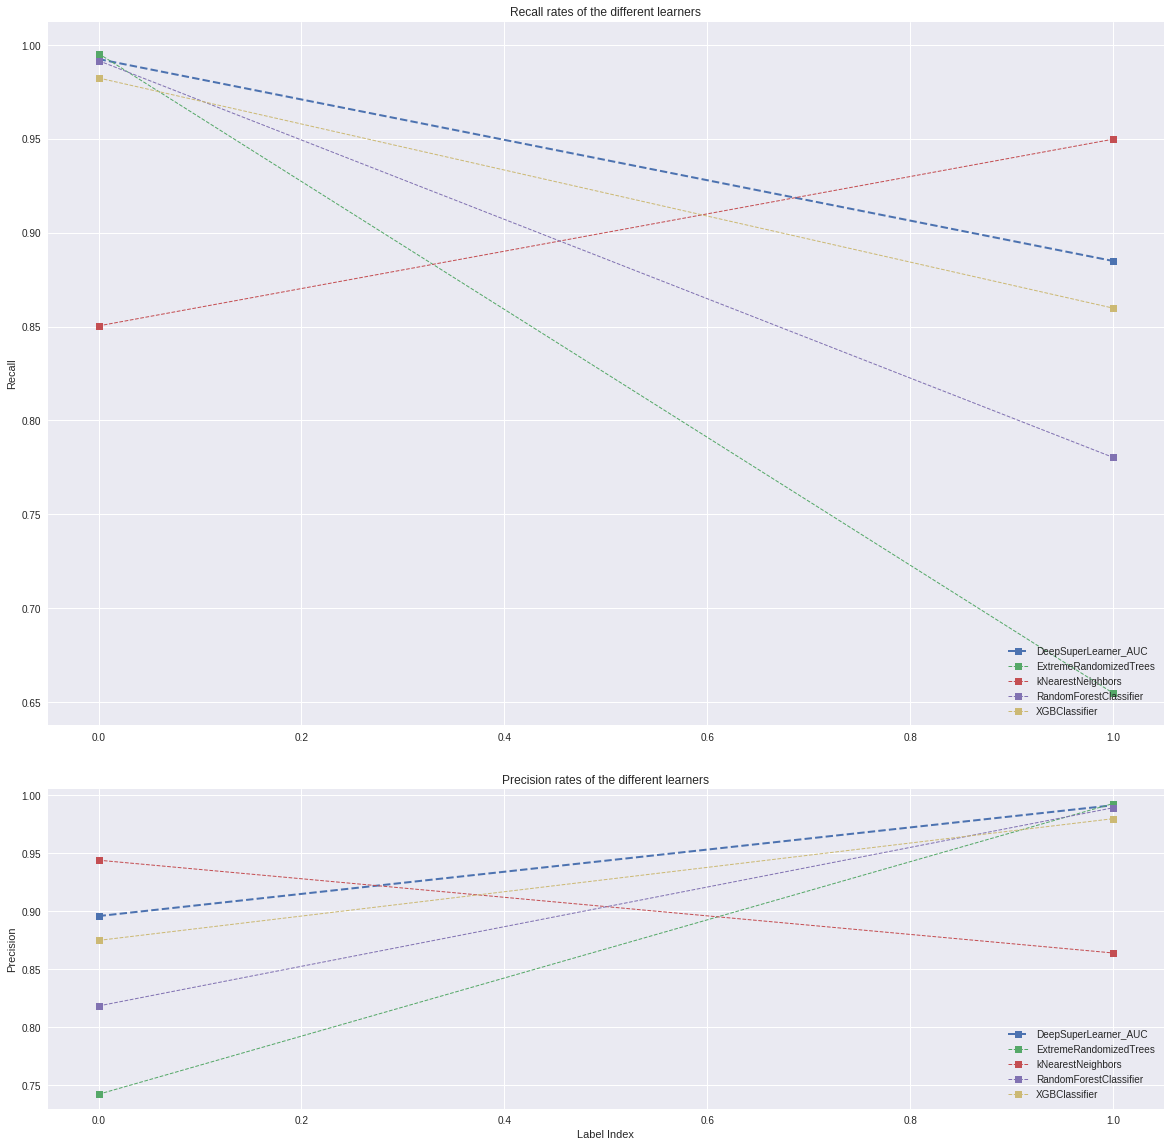

(array([0.99245599, 0.88493724]),
 array([0.89595157, 0.99156118]),
 [array([0.99538977, 0.65481172]),
  array([0.8503772 , 0.94979079]),
  array([0.99161777, 0.78033473]),
  array([0.98239732, 0.85983264])],
 [array([0.7421875, 0.9930203]),
  array([0.94416007, 0.86410354]),
  array([0.81840194, 0.98938992]),
  array([0.87495334, 0.97997139])])

In [35]:
ERT_learner = ExtremeRandomizedTrees(n_estimators=200, max_depth=None, max_features=15)
kNN_learner = kNearestNeighbors(n_neighbors=11)
LR_learner = LogisticRegression(penalty='l2', C=1)
LR_learnerL1 = LogisticRegression(penalty='l1', C=0.1)
RFC_learner = RandomForestClassifier(n_estimators=200, max_depth=None)
XGB_learner = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.01)
Base_learners1 = {'ExtremeRandomizedTrees':ERT_learner, 'kNearestNeighbors':kNN_learner, 
                     'RandomForestClassifier':RFC_learner, 'XGBClassifier':XGB_learner}
DSL_learner_AUC = DeepSuperLearner_AUC(Base_learners1)
DSL_learner_AUC.fit(X_train, Y_train, max_iterations=50,sample_weight=None)
DSL_learner_AUC.get_precision_recall(X_test, Y_test, show_graphs=True)

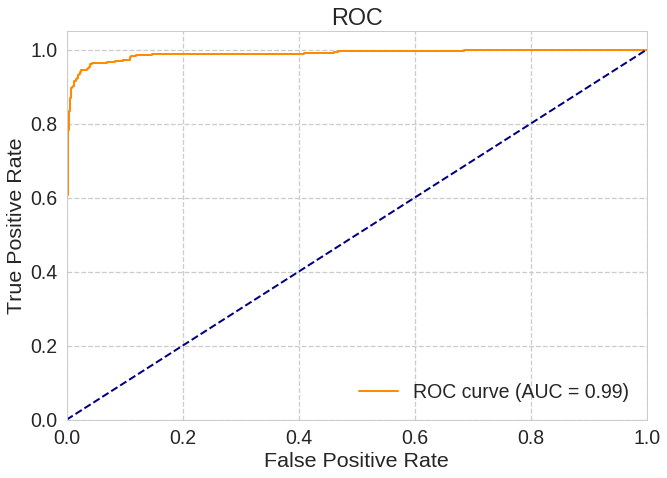

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
y_pred=DSL_learner_AUC.predict(X_test)

sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, 
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
fpr, tpr, _ = roc_curve(Y_test,y_pred[:,1])
auc = roc_auc_score(Y_test,y_pred[:,1])
lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# Generate predictions